In [1]:
# import libraries
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from os import path
from glob import glob
from tqdm import tqdm

from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA

from tensorflow import keras 

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from keras.layers import BatchNormalization
# from keras.preprocessing.image import img_to_array, load_img

In [2]:
# create directory paths for images (from dataset)
base_dir = '../../overview/project_data/COMPLETE_DATASET'
train_dir = path.join(base_dir, 'TRAIN')
test_dir = path.join(base_dir, 'TEST')

print(train_dir)
print(test_dir)

../../overview/project_data/COMPLETE_DATASET/TRAIN
../../overview/project_data/COMPLETE_DATASET/TEST


# EDA

In [3]:
# .jpg files of organic images from train data
train_org = glob(path.join(train_dir, 'O', '*.jpg'))
print('Number of organic (train) images: ', len(train_org))

Number of organic (train) images:  12565


In [4]:
# .jpg files of recyclable images from train data
train_re = glob(path.join(train_dir, 'R', '*.jpg'))
print('Number of recyclable (train) images: ', len(train_re))

Number of recyclable (train) images:  9999


In [5]:
# .jpg files of organic images from train data
test_org = glob(path.join(test_dir, 'O', '*.jpg'))
print('Number of organic (test) images: ', len(test_org))

Number of organic (test) images:  1401


In [6]:
# .jpg files of organic images from train data
test_re = glob(path.join(test_dir, 'R', '*.jpg'))
print('Number of recyclable (test) images: ', len(test_re))

Number of recyclable (test) images:  1112


In [7]:
print('Number of total (train + test) images: ', len(train_org)+len(train_re)+len(test_org)+len(test_re))
print('Number of train (organic + recyclable) images: ', len(train_org)+len(train_re))
print('Number of test (organic + recyclable) images: ', len(test_org)+len(test_re))

Number of total (train + test) images:  25077
Number of train (organic + recyclable) images:  22564
Number of test (organic + recyclable) images:  2513


In [8]:
x_data = []
y_data = []

for folder in glob(path.join(train_dir, '*')):
    for file in tqdm(glob(path.join(folder, '*.jpg'))):
        img_array = plt.imread(file)
        x_data.append(img_array)
        y_data.append(folder.split('/')[-1])

train_data = pd.DataFrame({'image': x_data, 'label': y_data})

100%|██████████████████████████████████████████████████████████████████| 12565/12565 [00:19<00:00, 636.94it/s]


In [9]:
train_data.shape

(22564, 2)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22564 entries, 0 to 22563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   22564 non-null  object
 1   label   22564 non-null  object
dtypes: object(2)
memory usage: 352.7+ KB


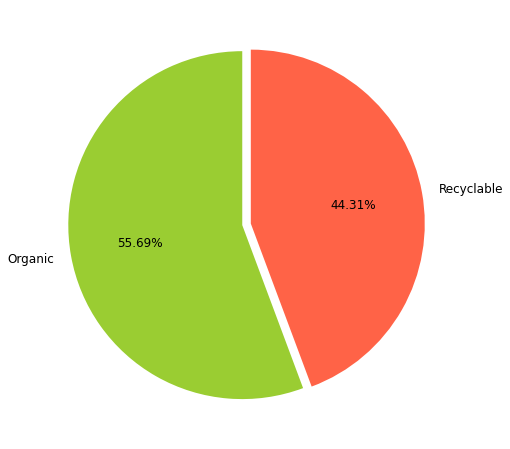

In [11]:
# pie chart of classes

plt.figure(figsize=(8,8))
plt.pie(train_data.label.value_counts(), 
        explode=[0.025,0.025],
        colors=['yellowgreen', 'tomato'],
        labels=['Organic', 'Recyclable'],
        autopct='%.2f%%',
        startangle=90,
        textprops={'fontsize':12})
plt.show();

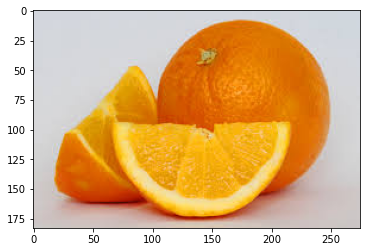

In [12]:
# read and display organic image
plt.imshow(plt.imread(train_org[8]))

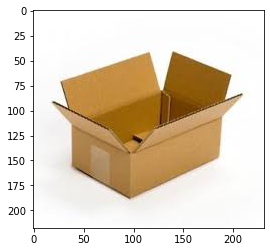

In [13]:
# read and display recyclable images
plt.imshow(plt.imread(train_re[1]))

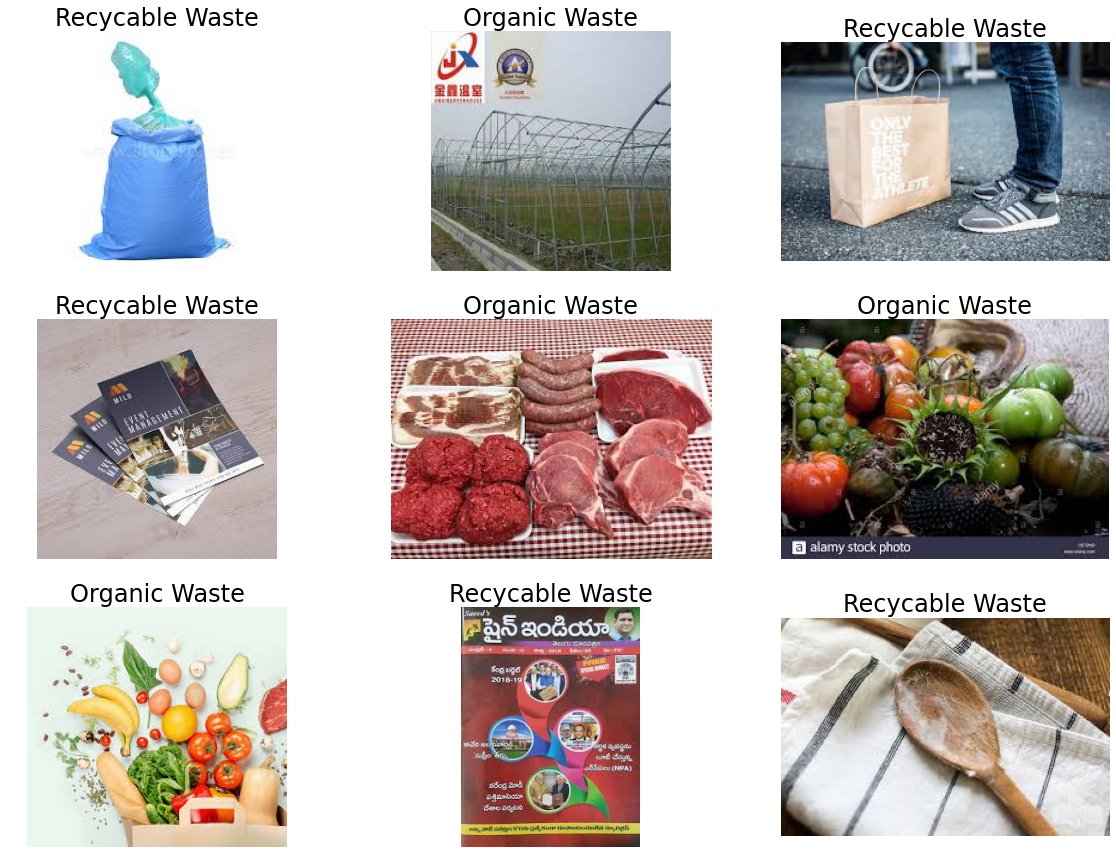

In [14]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,(i%12)+1)
    index=np.random.randint(22000)
    
    plt.imshow(train_data.image[index])
    plt.axis('off')
    
    if train_data.label[index] == 'O':
        plt.title('Organic Waste', fontdict={'size':24})
    else:
        plt.title('Recycable Waste', fontdict={'size':24})
    
plt.show()

In [15]:
# return shape for first 10 organic images
for img in train_org[0:10]:
    print((plt.imread(img)).shape)

(225, 225, 3)
(224, 224, 3)
(191, 264, 3)
(168, 300, 3)
(183, 276, 3)
(240, 210, 3)
(194, 259, 3)
(195, 258, 3)
(183, 275, 3)
(183, 276, 3)


In [16]:
# return shape for first 10 recyclable images
for img in train_re[0:10]:
    print((plt.imread(img)).shape)

(168, 300, 3)
(218, 231, 3)
(225, 225, 3)
(133, 380, 3)
(177, 284, 3)
(177, 285, 3)
(267, 189, 3)
(169, 297, 3)
(275, 183, 3)
(275, 183, 3)


# IMAGE PREPROCESSING

In [17]:
# image scaling
data_generator = ImageDataGenerator(rescale = 1.0 / 255.0)

In [18]:
# initialize train, validation, testing generator
train_generator = data_generator.flow_from_directory(
    train_dir,
    class_mode='binary',
    batch_size=32,
    seed=42)

test_generator = data_generator.flow_from_directory(
    test_dir, 
    class_mode='binary',
    batch_size=32,
    seed=42)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [19]:
train_generator.class_indices

{'O': 0, 'R': 1}

In [20]:
# iterate batches -> store the data in x_train, y_train
train_generator.reset()
x_train, y_train = next(train_generator)

#1st batch is already fetched before the for loop
for i in tqdm(range(int(len(train_generator)/32)-1)): 
    img, label = next(train_generator)
    x_train = np.append(x_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(x_train.shape, y_train.shape)

100%|█████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  3.95it/s]

(704, 256, 256, 3) (704,)


In [21]:
# iterate batches -> store the data in x_test, y_test
test_generator.reset()
x_test, y_test = next(test_generator)

#1st batch is already fetched before the for loop.
for i in tqdm(range(int(len(test_generator)/32)-1)): 
    img, label = next(test_generator)
    x_test = np.append(x_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(x_test.shape, y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]

(64, 256, 256, 3) (64,)


# NON DEEP LEARNING MODEL (RANDOM FOREST)

In [22]:
print(x_train.ndim)
print(x_test.ndim)

4
4


In [23]:
# reshape x_train values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_train.shape
x_train_2d = x_train.reshape((nsamples,nx*ny*nrgb))

In [24]:
# reshape x_test values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_test.shape
x_test_2d = x_test.reshape((nsamples,nx*ny*nrgb))

In [25]:
# reduce train data dimensions using PCA
pca = PCA(n_components=2)
pca.fit(x_train_2d)
x_train_2pc = pca.transform(x_train_2d)

# reduce test data dimensions using PCA
pca.fit(x_test_2d)
x_test_2pc = pca.transform(x_test_2d)

print(np.shape(x_train_2pc))
print(np.shape(x_test_2pc))

(704, 2)
(64, 2)


Text(0, 0.5, 'PCA Component 2')

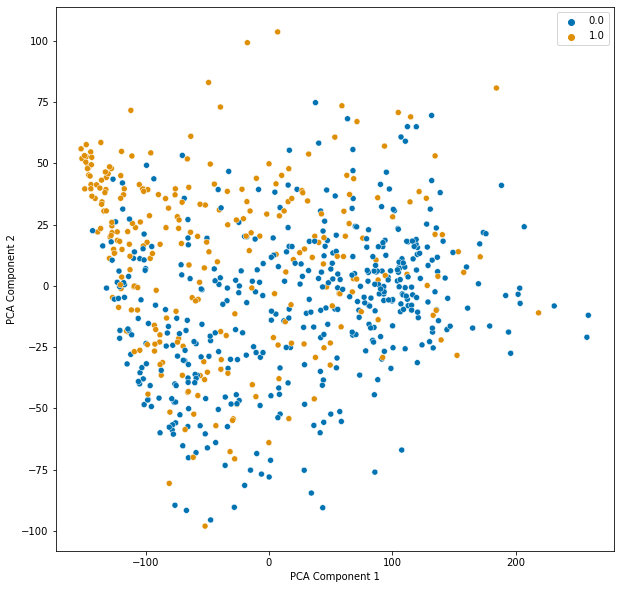

In [26]:
# plot PCA
plt.figure(figsize=(10,10))

sns.scatterplot(x=x_train_2pc[:, 0], y=x_train_2pc[:, 1],
                hue=y_train,
                palette=sns.color_palette("colorblind", 2))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

In [27]:
# instantiate and fit non deep learning model
rf = ensemble.RandomForestRegressor(n_estimators=100)

rf.fit(x_train_2pc,y_train)

RandomForestRegressor()

In [28]:
# evaluate random forest
rf_y_pred = rf.predict(x_test_2pc)
rf_y_pred

array([0.93, 0.47, 0.43, 0.88, 0.98, 0.16, 0.38, 0.42, 0.17, 0.27, 0.74,
       0.25, 0.1 , 0.52, 0.12, 0.08, 0.95, 0.64, 0.51, 0.42, 0.13, 0.26,
       0.04, 0.47, 0.47, 0.55, 0.95, 0.38, 0.01, 0.23, 0.13, 0.48, 0.11,
       0.56, 0.38, 0.12, 0.47, 0.01, 0.1 , 0.26, 0.16, 0.66, 0.32, 0.43,
       0.96, 0.35, 0.71, 0.42, 0.56, 0.24, 0.36, 0.61, 0.2 , 0.53, 0.67,
       0.52, 0.24, 0.17, 0.44, 0.06, 0.35, 0.55, 0.32, 0.  ])

In [29]:
print(rf_y_pred.shape)
print(type(rf_y_pred))

(64,)
<class 'numpy.ndarray'>


In [30]:
# evaluate using log loss
# where y_pred are probabilities and y_true are binary class labels
print(f"Random Forest Log Loss: {metrics.log_loss(y_test, rf_y_pred, eps=1e-15):,.4f}")

Random Forest Log Loss: 1.6291


In [31]:
# convert y_pred probabilities into binary labels
rf_y_pred = np.array([1.0 if obj >= 0.5 else 0 for obj in rf_y_pred])
rf_y_pred

array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.])

In [32]:
print(rf_y_pred.shape)
print(type(rf_y_pred))

(64,)
<class 'numpy.ndarray'>


In [33]:
# evaluate
print(f"Random Forest MAE: {metrics.mean_absolute_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest MSE: {metrics.mean_squared_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest Accuracy: {metrics.accuracy_score(y_test, rf_y_pred):,.4f}")

Random Forest MAE: 0.6094
Random Forest MSE: 0.6094
Random Forest Accuracy: 0.3906


# SIMPLE NEURAL NET

In [34]:
x_train.shape[1:]

(256, 256, 3)

In [35]:
snn = Sequential()

snn.add(Flatten(input_shape=x_train.shape[1:]))
snn.add(Dense(units=80, activation='relu'))
snn.add(Dense(units=40, activation='relu'))
snn.add(Dense(units=20, activation='relu'))
snn.add(Dense(units=10, activation='relu'))
snn.add(Dense(units=1, activation='sigmoid'))

snn.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
snn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 80)                15728720  
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 15,733,001
Trainable params: 15,733,001
No

2022-09-07 05:24:03.878755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
x_train.shape

(704, 256, 256, 3)

In [37]:
y_train.shape

(704,)

In [38]:
snn.fit(x_train, y_train, epochs=20, verbose=1)

Epoch 1/20
22/22 [==============================] - 2s 60ms/step - loss: 3.1281 - accuracy: 0.5625
Epoch 2/20
22/22 [==============================] - 1s 59ms/step - loss: 0.6414 - accuracy: 0.6847
Epoch 3/20
22/22 [==============================] - 2s 72ms/step - loss: 0.6084 - accuracy: 0.7315
Epoch 4/20
22/22 [==============================] - 1s 63ms/step - loss: 0.4965 - accuracy: 0.7969
Epoch 5/20
22/22 [==============================] - 1s 59ms/step - loss: 0.4489 - accuracy: 0.8111
Epoch 6/20
22/22 [==============================] - 1s 62ms/step - loss: 0.4644 - accuracy: 0.8082
Epoch 7/20
22/22 [==============================] - 1s 59ms/step - loss: 0.4350 - accuracy: 0.8267
Epoch 8/20
22/22 [==============================] - 1s 60ms/step - loss: 0.3841 - accuracy: 0.8494
Epoch 9/20
22/22 [==============================] - 1s 61ms/step - loss: 0.4064 - accuracy: 0.8324
Epoch 10/20
22/22 [==============================] - 1s 60ms/step - loss: 0.3776 - accuracy: 0.8565
Epoch 11/

In [39]:
# evaluate simple neural net model
snn.evaluate(x_test,y_test)

2/2 [==============================] - 0s 12ms/step - loss: 0.4703 - accuracy: 0.7969


[0.4702582061290741, 0.796875]

In [40]:
# evaluate simple neural net model
snn_y_pred = snn.predict(x_test)

2/2 [==============================] - 0s 12ms/step


In [41]:
print(snn_y_pred.shape)
print(type(snn_y_pred))

(64, 1)
<class 'numpy.ndarray'>


In [42]:
# evaluate using log loss
# where y_pred are probabilities and y_true are binary class labels
print(f"Simple Neural Net Log Loss: {metrics.log_loss(y_test, snn_y_pred, eps=1e-15):,.4f}")

Simple Neural Net Log Loss: 0.4703


In [43]:
# convert y_pred probabilities into binary labels
snn_y_pred = np.array([1.0 if obj >= 0.5 else 0 for obj in snn_y_pred])
snn_y_pred

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.])

In [44]:
print(snn_y_pred.shape)
print(type(snn_y_pred))

(64,)
<class 'numpy.ndarray'>


In [45]:
# evaluate using MAE, MSE, Accuracy
print(f"Simple Neural Net MAE: {metrics.mean_absolute_error(y_test, snn_y_pred):,.4f}")
print(f"Simple Neural Net MSE: {metrics.mean_squared_error(y_test, snn_y_pred):,.4f}")
print(f"Simple Neural Net Accuracy: {metrics.accuracy_score(y_test, snn_y_pred):,.4f}")

Simple Neural Net MAE: 0.2031
Simple Neural Net MSE: 0.2031
Simple Neural Net Accuracy: 0.7969


# IMAGE PREPROCESSING

In [46]:
# image scaling
train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [47]:
# initialize train, validation, testing generator
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42)

valid_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [48]:
# iterate batches -> store the data in x_train, y_train
train_generator.reset()
x_train, y_train = next(train_generator)

#1st batch is already fetched before the for loop
for i in tqdm(range(int(len(train_generator)/batch_size)-1)): 
    img, label = next(train_generator)
    x_train = np.append(x_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(x_train.shape, y_train.shape)

100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.23it/s]

(544, 256, 256, 3) (544, 2)


In [49]:
# iterate batches -> store the data in x_valid, y_valid
valid_generator.reset()
x_valid, y_valid = next(valid_generator)

#1st batch is already fetched before the for loop.
for i in tqdm(range(int(len(valid_generator)/batch_size)-1)): 
    img, label = next(valid_generator)
    x_valid = np.append(x_valid, img, axis=0 )
    y_valid = np.append(y_valid, label, axis=0)

print(x_valid.shape, y_valid.shape)

100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.70it/s]

(128, 256, 256, 3) (128, 2)


In [50]:
# iterate batches -> store the data in x_test, y_test
test_generator.reset()
x_test, y_test = next(test_generator)

#1st batch is already fetched before the for loop.
for i in tqdm(range(int(len(test_generator)/batch_size)-1)): 
    img, label = next(test_generator)
    x_test = np.append(x_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(x_test.shape, y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.90it/s]

(64, 256, 256, 3) (64, 2)


# SIMPLE CNN

In [51]:
model = Sequential()

model.add(InputLayer(input_shape=(256,256,3)))

model.add(Conv2D(filters=16,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Flatten())
    
model.add(Dense(16, activation='relu'))
    
model.add(Dense(2, activation='sigmoid'))
    
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 258064)            0         
                                                                 
 dense_5 (Dense)             (None, 16)                4129040   
                                                                 
 dense_6 (Dense)             (None, 2)                 34        
                                                                 
Total params: 4,129,522
Trainable params: 4,129,522
Non-trainable params: 0
____________________________________________

In [52]:
model.fit(x_train, y_train, epochs=20, verbose=1)

Epoch 1/20
17/17 [==============================] - 5s 265ms/step - loss: 3.0148 - accuracy: 0.5846
Epoch 2/20
17/17 [==============================] - 5s 282ms/step - loss: 0.5638 - accuracy: 0.7261
Epoch 3/20
17/17 [==============================] - 5s 266ms/step - loss: 0.4803 - accuracy: 0.7426
Epoch 4/20
17/17 [==============================] - 5s 266ms/step - loss: 0.4087 - accuracy: 0.7978
Epoch 5/20
17/17 [==============================] - 5s 277ms/step - loss: 0.3479 - accuracy: 0.8364
Epoch 6/20
17/17 [==============================] - 5s 280ms/step - loss: 0.2864 - accuracy: 0.8585
Epoch 7/20
17/17 [==============================] - 5s 302ms/step - loss: 0.2321 - accuracy: 0.8952
Epoch 8/20
17/17 [==============================] - 6s 326ms/step - loss: 0.1981 - accuracy: 0.9136
Epoch 9/20
17/17 [==============================] - 5s 277ms/step - loss: 0.1667 - accuracy: 0.9375
Epoch 10/20
17/17 [==============================] - 5s 318ms/step - loss: 0.1278 - accuracy: 0.9504

In [53]:
# evaluate model with validation
simple_cnn_valid_evaluate = model.evaluate(x_valid,y_valid)
simple_cnn_valid_evaluate

4/4 [==============================] - 0s 99ms/step - loss: 0.8321 - accuracy: 0.7891


[0.8321353793144226, 0.7890625]

In [54]:
# evaluate model
simple_cnn_evaluate = model.evaluate(x_test,y_test)
simple_cnn_evaluate

2/2 [==============================] - 0s 97ms/step - loss: 0.5681 - accuracy: 0.7969


[0.5681024193763733, 0.796875]

In [55]:
# model predictions
simple_cnn_y_pred = model.predict(x_test)

2/2 [==============================] - 0s 95ms/step


In [56]:
# evaluate using log loss
# where y_pred are probabilities and y_true are binary class labels
print(f"Simple CNN Log Loss: {metrics.log_loss(y_test, simple_cnn_y_pred, eps=1e-15):,.4f}")

Simple CNN Log Loss: 0.4896


In [57]:
print(y_test.shape)
print(y_test[0])
print(type(y_test[0]))

(64, 2)
[1. 0.]
<class 'numpy.ndarray'>


In [58]:
print(simple_cnn_y_pred.shape)
print(simple_cnn_y_pred[0])
print(type(simple_cnn_y_pred[0]))

(64, 2)
[0.9993937  0.00220852]
<class 'numpy.ndarray'>


In [59]:
# evaluate using MAE, MSE, Accuracy
print(f"Simple CNN MAE: {metrics.mean_absolute_error(y_test, simple_cnn_y_pred):,.4f}")
print(f"Simple CNN MSE: {metrics.mean_squared_error(y_test, simple_cnn_y_pred):,.4f}")
print(f"Simple CNN Accuracy: {simple_cnn_evaluate[1]:,.4f}")

Simple CNN MAE: 0.2094
Simple CNN MSE: 0.1367
Simple CNN Accuracy: 0.7969


In [60]:
# print(f"Simple CNN Accuracy: {metrics.accuracy_score(y_test, simple_cnn_y_pred):,.4f}")

# COMPLEX CNN

In [61]:
model = Sequential()

model.add(InputLayer(input_shape=(256,256,3)))

model.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(2, activation='sigmoid')) 

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)      

In [62]:
model.fit(x_train, y_train, epochs=20, verbose=1)

Epoch 1/20
17/17 [==============================] - 11s 629ms/step - loss: 0.6513 - accuracy: 0.6176
Epoch 2/20
17/17 [==============================] - 11s 639ms/step - loss: 0.4954 - accuracy: 0.7721
Epoch 3/20
17/17 [==============================] - 11s 657ms/step - loss: 0.5371 - accuracy: 0.7408
Epoch 4/20
17/17 [==============================] - 11s 630ms/step - loss: 0.4614 - accuracy: 0.7960
Epoch 5/20
17/17 [==============================] - 11s 636ms/step - loss: 0.4105 - accuracy: 0.8217
Epoch 6/20
17/17 [==============================] - 10s 612ms/step - loss: 0.3437 - accuracy: 0.8566
Epoch 7/20
17/17 [==============================] - 10s 617ms/step - loss: 0.2816 - accuracy: 0.8860
Epoch 8/20
17/17 [==============================] - 10s 616ms/step - loss: 0.2258 - accuracy: 0.9154
Epoch 9/20
17/17 [==============================] - 11s 628ms/step - loss: 0.2740 - accuracy: 0.8934
Epoch 10/20
17/17 [==============================] - 11s 635ms/step - loss: 0.1840 - accura

In [63]:
complex_cnn_valid_evaluate = model.evaluate(x_valid,y_valid)
complex_cnn_valid_evaluate

4/4 [==============================] - 1s 168ms/step - loss: 1.8592 - accuracy: 0.6953


[1.8591666221618652, 0.6953125]

In [64]:
complex_cnn_evaluate = model.evaluate(x_test,y_test)
complex_cnn_evaluate

2/2 [==============================] - 0s 169ms/step - loss: 2.0005 - accuracy: 0.7656


[2.0005006790161133, 0.765625]

In [65]:
complex_cnn_y_pred = model.predict(x_test)

2/2 [==============================] - 0s 169ms/step


In [66]:
print(f"Complex CNN Log Loss: {metrics.log_loss(y_test, complex_cnn_y_pred, eps=1e-15):,.4f}")

Complex CNN Log Loss: 2.0085


In [67]:
print(f"Complex CNN MAE: {metrics.mean_absolute_error(y_test, complex_cnn_y_pred):,.4f}")
print(f"Complex CNN MSE: {metrics.mean_squared_error(y_test, complex_cnn_y_pred):,.4f}")
print(f"Complex CNN Accuracy: {complex_cnn_evaluate[1]:,.4f}")

Complex CNN MAE: 0.2555
Complex CNN MSE: 0.2123
Complex CNN Accuracy: 0.7656


# MOVE MORE COMPLEX CNN TO GOOGLE COLAB

In [68]:
# tf.data.experimental.enable_debug_mode()
# tf.config.run_functions_eagerly(True)

In [69]:
# history = model.fit(train_generator,
#                     epochs=10,
#                     validation_data=valid_generator)

In [70]:
# plt.figure(figsize=[10,6])
# plt.plot(hist.history["accuracy"], label = "Train acc")
# plt.plot(hist.history["val_accuracy"], label = "Validation acc")
# plt.legend()
# plt.show()

In [71]:
# plt.figure(figsize=(10,6))
# plt.plot(hist.history['loss'], label = "Train loss")
# plt.plot(hist.history['val_loss'], label = "Validation loss")
# plt.legend()
# plt.show()

In [72]:
# def predict_func(img): 
#     plt.figure(figsize=(6,4))
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.tight_layout()
#     img = cv2.resize(img, (224, 224))
#     img = np.reshape(img, [-1, 224, 224,3])
#     result = np.argmax(model.predict(img))
#     if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
#     elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

In [73]:
# test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12573.jpg")
# predict_func(test_img)